In [1]:
from datasets import Dataset, DatasetDict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from google.colab import drive
import random
import torch
from torch.utils.data import DataLoader

In [3]:
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/magisterka'
%cd /content/drive/My Drive/magisterka

Mounted at /content/drive
/content/drive/My Drive/magisterka


In [4]:
from model_training.mlm_unlabeled_trainer import MLMUnlabeledDataTrainer

In [5]:
models_path = f'{base_path}/data/results'
articles_checkpoint = 'finbert_articles_final'
reddit_checkpoint = 'finbert_reddit_final_labeled'
reddit_unlabeled_checkpoint = 'finbert_reddit_final'

In [6]:
def load_labeled_dataset(path: str, label2id: dict[str, int]) -> Dataset:
  df = pd.read_csv(path)
  df['labels'] = df['label'].apply(lambda x: label2id.get(x, 1))
  df = df[['text', 'labels']]
  return Dataset.from_pandas(df)

### articles prediction evaluation

In [7]:
articles_model = MLMUnlabeledDataTrainer(final_checkpoint=articles_checkpoint, mlm_checkpoint='not_needed', models_path=models_path)

In [8]:
articles_dataset = load_labeled_dataset(f"{base_path}/data/results/sample_test_dataset_finlight.csv", articles_model.label2id)

In [9]:
tokenized_articles = articles_dataset.map(articles_model.tokenize, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [10]:
articles_model.init_final_model(articles_model.final_checkpoint)

In [11]:
tokenized_articles.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

In [12]:
dataloader = DataLoader(tokenized_articles, batch_size=32, shuffle=False)

In [13]:
all_preds = []
all_labels = []
for batch in dataloader:
  batch = {k: v.to("cuda") for k, v in batch.items()}
  with torch.no_grad():
    output = articles_model.final_model(**batch)
    logits = output.logits
    preds = torch.argmax(logits, dim=1)
  all_preds.extend(preds.cpu().numpy())
  all_labels.extend(batch["labels"].cpu().numpy())

In [22]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt


In [25]:
def evaluate_predictions(predictions, labels, target_names=["negative", "neutral", "positive"]):
  accuracy = accuracy_score(labels, predictions)
  macro_f1 = f1_score(labels, predictions, average="macro")
  weighted_f1 = f1_score(labels, predictions, average="weighted")

  print("Accuracy:", accuracy)
  print("Macro F1:", macro_f1)
  print("Weighted F1:", weighted_f1)

  print("\nClassification report:")
  print(classification_report(labels, predictions, target_names=target_names))

  print("\nConfusion matrix:")
  cm = confusion_matrix(labels, predictions)
  print(cm)
  fig, ax = plt.subplots(figsize=(6, 5))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

  plt.colorbar(im, ax=ax)
  ax.set(
    xticks=np.arange(len(target_names)),
    yticks=np.arange(len(target_names)),
    xticklabels=target_names,
    yticklabels=target_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
  )
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(
              j, i, format(cm[i, j], "d"),
              ha="center",
              va="center",
              color="white" if cm[i, j] > thresh else "black"
          )

  plt.tight_layout()
  plt.show()
  return {"accuracy": accuracy, "macro_f1": macro_f1, "weighted_f1": weighted_f1}

In [17]:
pred_labels = [articles_model.id2label[pred] for pred in all_preds]
actual_labels = [articles_model.id2label[label] for label in all_labels]

In [18]:
texts = articles_dataset.to_dict()["text"]

In [19]:
result_df = pd.DataFrame({'text': texts, 'predicted_label': pred_labels, 'actual_label': actual_labels})

In [20]:
result_df.to_csv(f"{base_path}/data/results/finbert_articles_prediction_test.csv", index=False)

Accuracy: 0.65
Macro F1: 0.6495983935742972
Weighted F1: 0.6565763052208835

Classification report:
              precision    recall  f1-score   support

    negative       0.60      0.75      0.67        20
     neutral       0.51      0.68      0.58        31
    positive       0.85      0.59      0.70        49

    accuracy                           0.65       100
   macro avg       0.66      0.67      0.65       100
weighted avg       0.70      0.65      0.66       100


Confusion matrix:
[[15  4  1]
 [ 6 21  4]
 [ 4 16 29]]


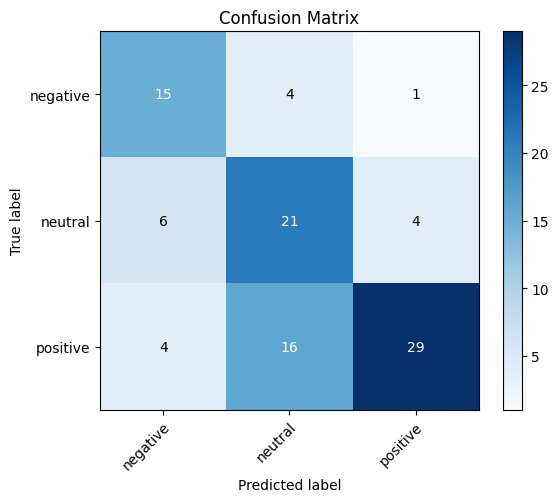

{'accuracy': 0.65,
 'macro_f1': 0.6495983935742972,
 'weighted_f1': 0.6565763052208835}

In [24]:
evaluate_predictions(all_preds, all_labels, ["negative", "neutral", "positive"])

### reddit comments evaluation

In [49]:
reddit_model = MLMUnlabeledDataTrainer(final_checkpoint=reddit_checkpoint, mlm_checkpoint='not_needed', models_path=models_path)

In [50]:
comments_dataset = load_labeled_dataset(f"{base_path}/data/results/sample_test_dataset_reddit.csv", articles_model.label2id)

In [51]:
tokenized_comments = comments_dataset.map(reddit_model.tokenize, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [52]:
reddit_model.init_final_model(reddit_model.final_checkpoint)

In [53]:
tokenized_comments.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

In [54]:
data_loader = DataLoader(tokenized_comments, batch_size=32, shuffle=False)

In [55]:
all_preds = []
all_labels = []
for batch in data_loader:
  batch = {k: v.to("cuda") for k, v in batch.items()}
  with torch.no_grad():
    output = reddit_model.final_model(**batch)
    logits = output.logits
    preds = torch.argmax(logits, dim=1)
  all_preds.extend(preds.cpu().numpy())
  all_labels.extend(batch["labels"].cpu().numpy())

In [56]:
pred_labels = [articles_model.id2label[pred] for pred in all_preds]
actual_labels = [articles_model.id2label[label] for label in all_labels]
texts = comments_dataset.to_dict()["text"]

In [57]:
result_df = pd.DataFrame({'text': texts, 'predicted_label': pred_labels, 'actual_label': actual_labels})

In [58]:
result_df.to_csv(f"{base_path}/data/results/finbert_reddit_predictions_test.csv", index=False)

Accuracy: 0.73
Macro F1: 0.46269050255761224
Weighted F1: 0.7038886252175288

Classification report:
              precision    recall  f1-score   support

    negative       0.67      0.48      0.56        25
     neutral       0.77      0.90      0.83        68
    positive       0.00      0.00      0.00         7

    accuracy                           0.73       100
   macro avg       0.48      0.46      0.46       100
weighted avg       0.69      0.73      0.70       100


Confusion matrix:
[[12 12  1]
 [ 5 61  2]
 [ 1  6  0]]


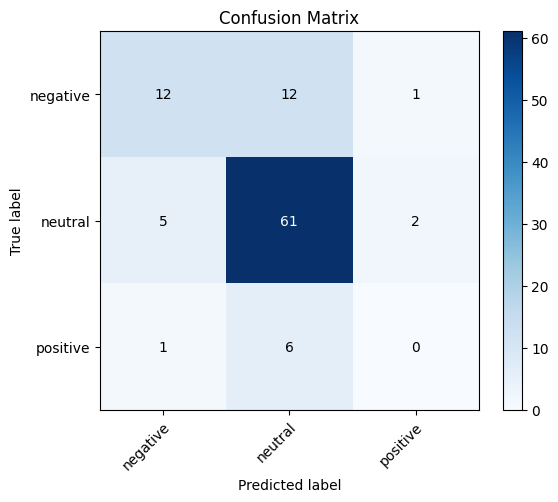

{'accuracy': 0.73,
 'macro_f1': 0.46269050255761224,
 'weighted_f1': 0.7038886252175288}

In [59]:
evaluate_predictions(all_preds, all_labels, ["negative", "neutral", "positive"])

### reddit comments evaluation - training on unlabeled data

In [60]:
reddit_model = MLMUnlabeledDataTrainer(final_checkpoint=reddit_unlabeled_checkpoint, mlm_checkpoint='not_needed', models_path=models_path)

In [61]:
comments_dataset = load_labeled_dataset(f"{base_path}/data/results/sample_test_dataset_reddit.csv", articles_model.label2id)

In [62]:
tokenized_comments = comments_dataset.map(reddit_model.tokenize, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [63]:
reddit_model.init_final_model(reddit_model.final_checkpoint)

In [64]:
tokenized_comments.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

In [65]:
data_loader = DataLoader(tokenized_comments, batch_size=32, shuffle=False)

In [66]:
all_preds = []
all_labels = []
for batch in data_loader:
  batch = {k: v.to("cuda") for k, v in batch.items()}
  with torch.no_grad():
    output = reddit_model.final_model(**batch)
    logits = output.logits
    preds = torch.argmax(logits, dim=1)
  all_preds.extend(preds.cpu().numpy())
  all_labels.extend(batch["labels"].cpu().numpy())

In [67]:
pred_labels = [articles_model.id2label[pred] for pred in all_preds]
actual_labels = [articles_model.id2label[label] for label in all_labels]
texts = comments_dataset.to_dict()["text"]

In [68]:
result_df = pd.DataFrame({'text': texts, 'predicted_label': pred_labels, 'actual_label': actual_labels})

In [69]:
result_df.to_csv(f"{base_path}/data/results/finbert_reddit_predictions_test_unlabeled.csv", index=False)

Accuracy: 0.71
Macro F1: 0.5283701726654747
Weighted F1: 0.6769871213495375

Classification report:
              precision    recall  f1-score   support

    negative       0.50      0.24      0.32        25
     neutral       0.77      0.91      0.83        68
    positive       0.43      0.43      0.43         7

    accuracy                           0.71       100
   macro avg       0.56      0.53      0.53       100
weighted avg       0.68      0.71      0.68       100


Confusion matrix:
[[ 6 16  3]
 [ 5 62  1]
 [ 1  3  3]]


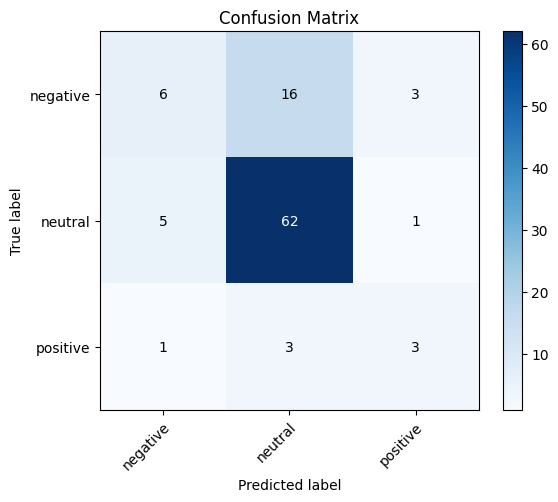

{'accuracy': 0.71,
 'macro_f1': 0.5283701726654747,
 'weighted_f1': 0.6769871213495375}

In [70]:
evaluate_predictions(all_preds, all_labels, ["negative", "neutral", "positive"])